# Spatial Embedding

This guide outlines the use of `nn.Embedding2d` for spatial convolution on a sphere projection that is flattened onto a 2-dimensional surface. It also explores potential problems this module could solve and how it is designed to address them.

<a target="_blank" href="https://colab.research.google.com/github/ybubnov/torch_geopooling/blob/main/docs/guide/spatial_embedding.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install torch-geopooling -qqq

## Problem

Suppose we have the task of learning a target function that depends, among other parameters, on longitude and latitude. The input data for this function is essentially a single point in 2-dimensional space, along with a set of other parameters ($n$):

$$
    f: X \mapsto \mathbb{R}
$$
$$
    X = \{ (\text{lon}, \text{lat}, ...) \in \mathbb{R}^{2+n} \}
$$

We recognize that co-located coordinates are likely to exhibit similar patterns in the function $f$. To make the learning process for $f$ more computationally efficient, we aim to divide the space into discrete units. This division of the 2-dimensional space, where each unit is associated with an independent vector of parameters, is what we refer to as an embedding.

## Reflection

A key advantage of `nn.Embedding2d` is its ability to reflect coordinates across both the X and Y axes. When considering a 2-dimensional space as a spherical surface, this means that coordinates on the right edge of the surface will be adjacent to those on the left edge. The example below illustrates how this module handles axis reflection.

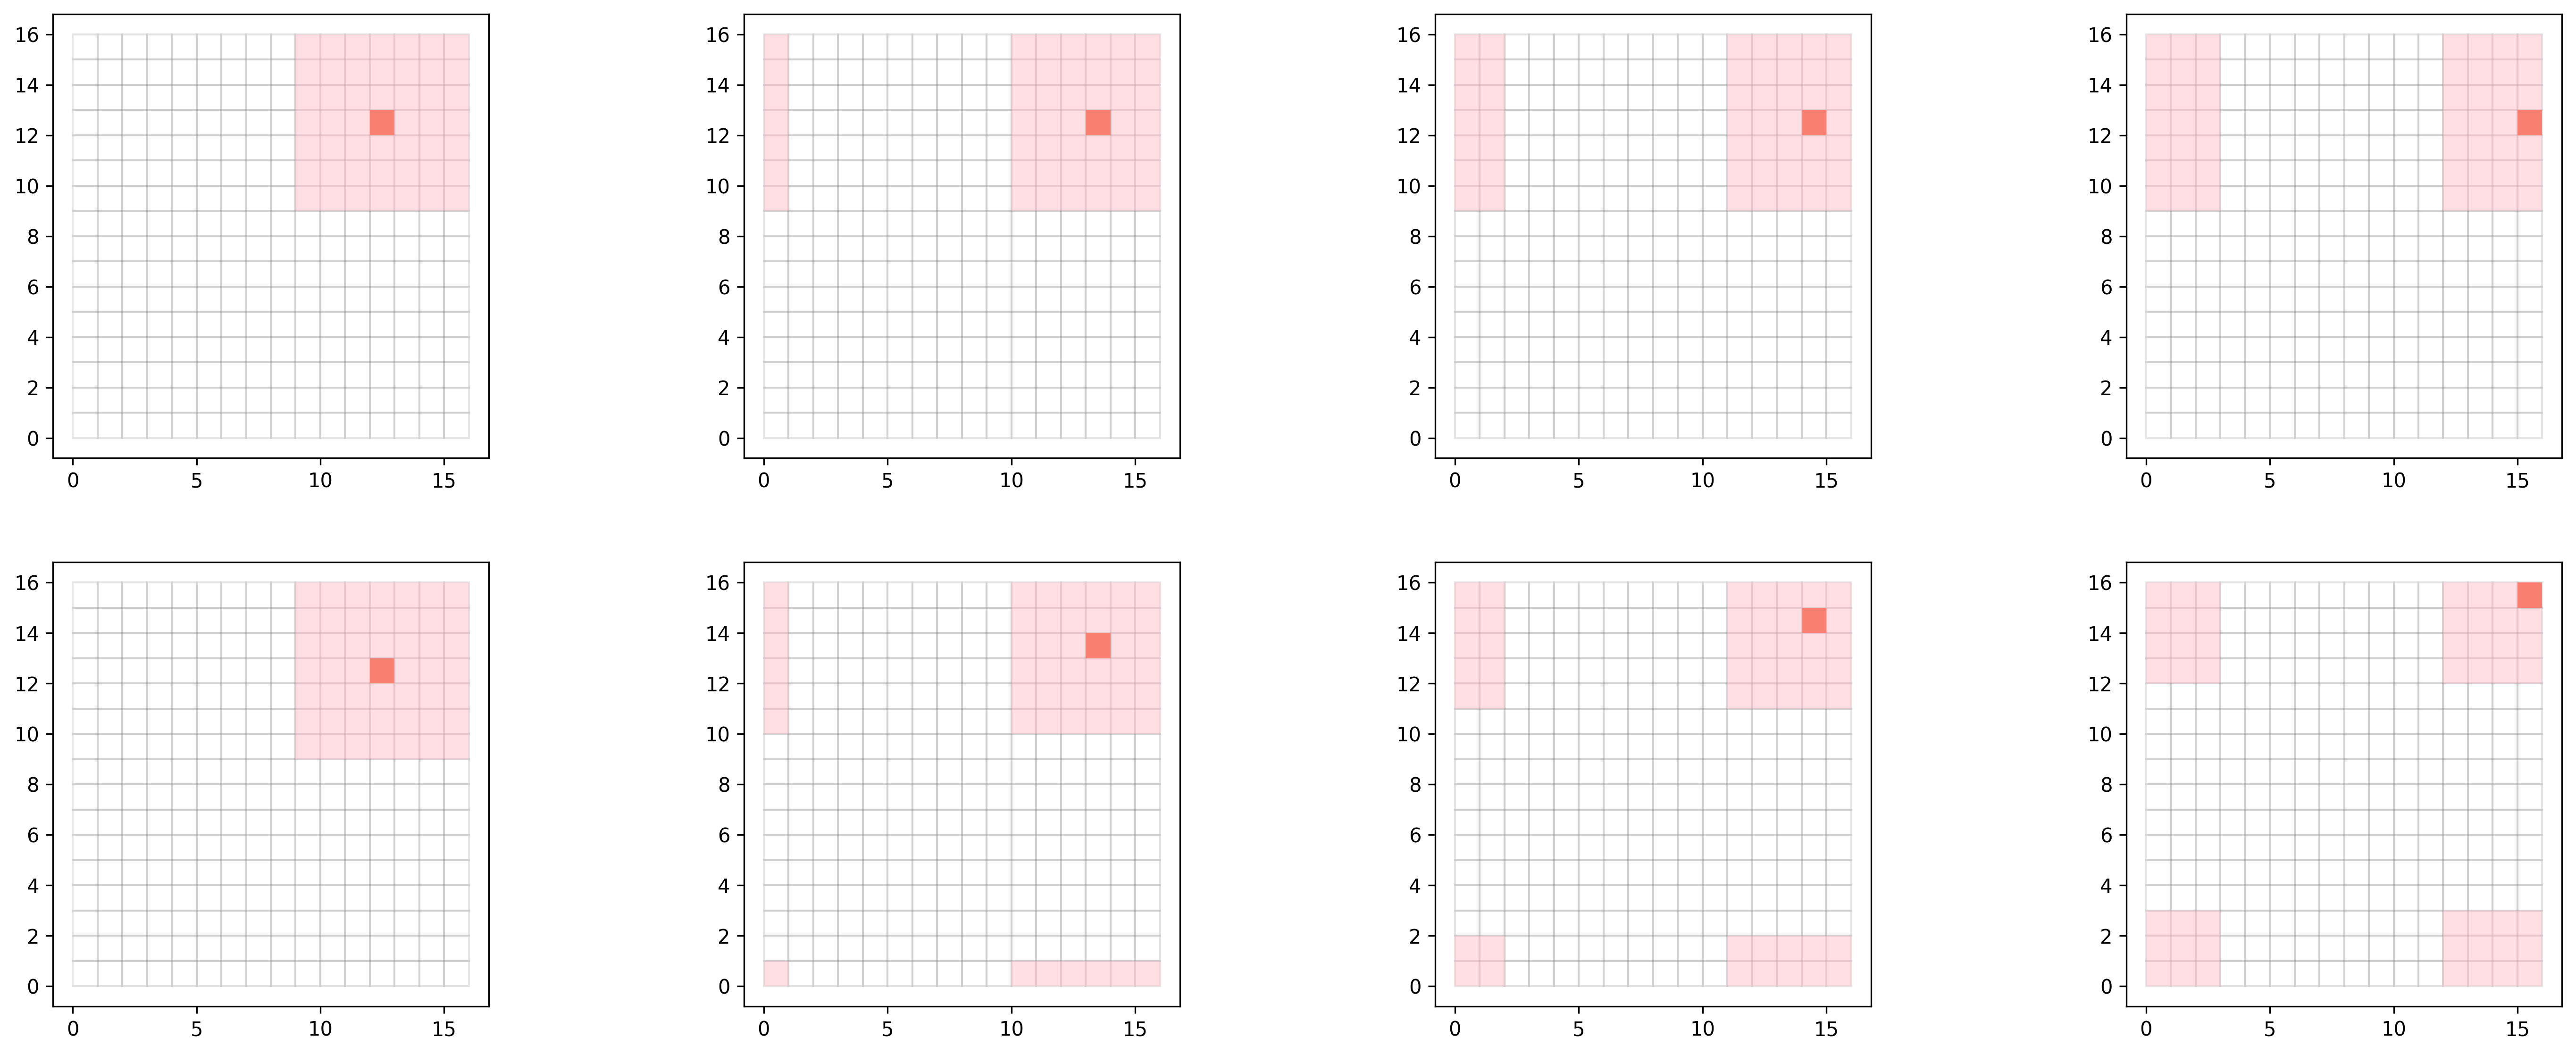

In [2]:
from shapely import Polygon
from matplotlib import pyplot as plot

def draw_poly(x, y, w, h):
    return Polygon([(x, y), (x+w, y), (x+w, y+h), (x, y+h), (x, y)])


fig, axes = plot.subplots(ncols=4, nrows=2)
fig.tight_layout()
fig.set_dpi(300)
fig.set_size_inches(20, 8)

width, height = 16, 16

for row in axes:
    for ax in row:
        for i in range(width):
            for j in range(height):
                ax.fill(
                    *draw_poly(i, j, 1, 1).exterior.xy,
                    facecolor="none",
                    edgecolor="gray",
                    alpha=0.2
                )

points = [(12, 12), (13, 12), (14, 12), (15, 12)]
padding_x, padding_y = 3, 3

# Move the point along the X-axis and wrap the kernel once it reaches the
# boundary of the manifold (16x16).
for i, (x, y) in enumerate(points):
    for j in range(x - padding_x, x + padding_x + 1):
        for k in range(y - padding_y, y + padding_y + 1):
            j = j % width
            axes[0][i].fill(
                *draw_poly(j, k, 1, 1).exterior.xy,
                facecolor="pink",
                edgecolor="none",
                alpha=0.5
            )
    axes[0][i].fill(*draw_poly(x, y, 1, 1).exterior.xy, facecolor="salmon")

# Move the point along the secondary diagonal, and wrap the kernel around both axis.
points = [(12, 12), (13, 13), (14, 14), (15, 15)]
for i, (x, y) in enumerate(points):
    for j in range(x - padding_x, x + padding_x + 1):
        for k in range(y - padding_y, y + padding_y + 1):
            k = k % height
            j = j % width
            axes[1][i].fill(
                *draw_poly(j, k, 1, 1).exterior.xy,
                facecolor="pink",
                edgecolor="none", alpha=0.5
            )
    axes[1][i].fill(*draw_poly(x, y, 1, 1).exterior.xy, facecolor="salmon")

A significant difference from `torch.nn.Conv2d` is that the input to the neural network is not the entire surface, but rather a single coordinate.

## Defining the Dataset

To further illustrate this example, let's explore an artificial regression problem focused on learning the direction and strength of a "force field" distributed over a sphere. The images below show the original data (left) and the training data (right). The training data consists of a random sample representing 50% of the original data.

The goal of this exercise is to reconstruct the "original picture" from its partial representation.

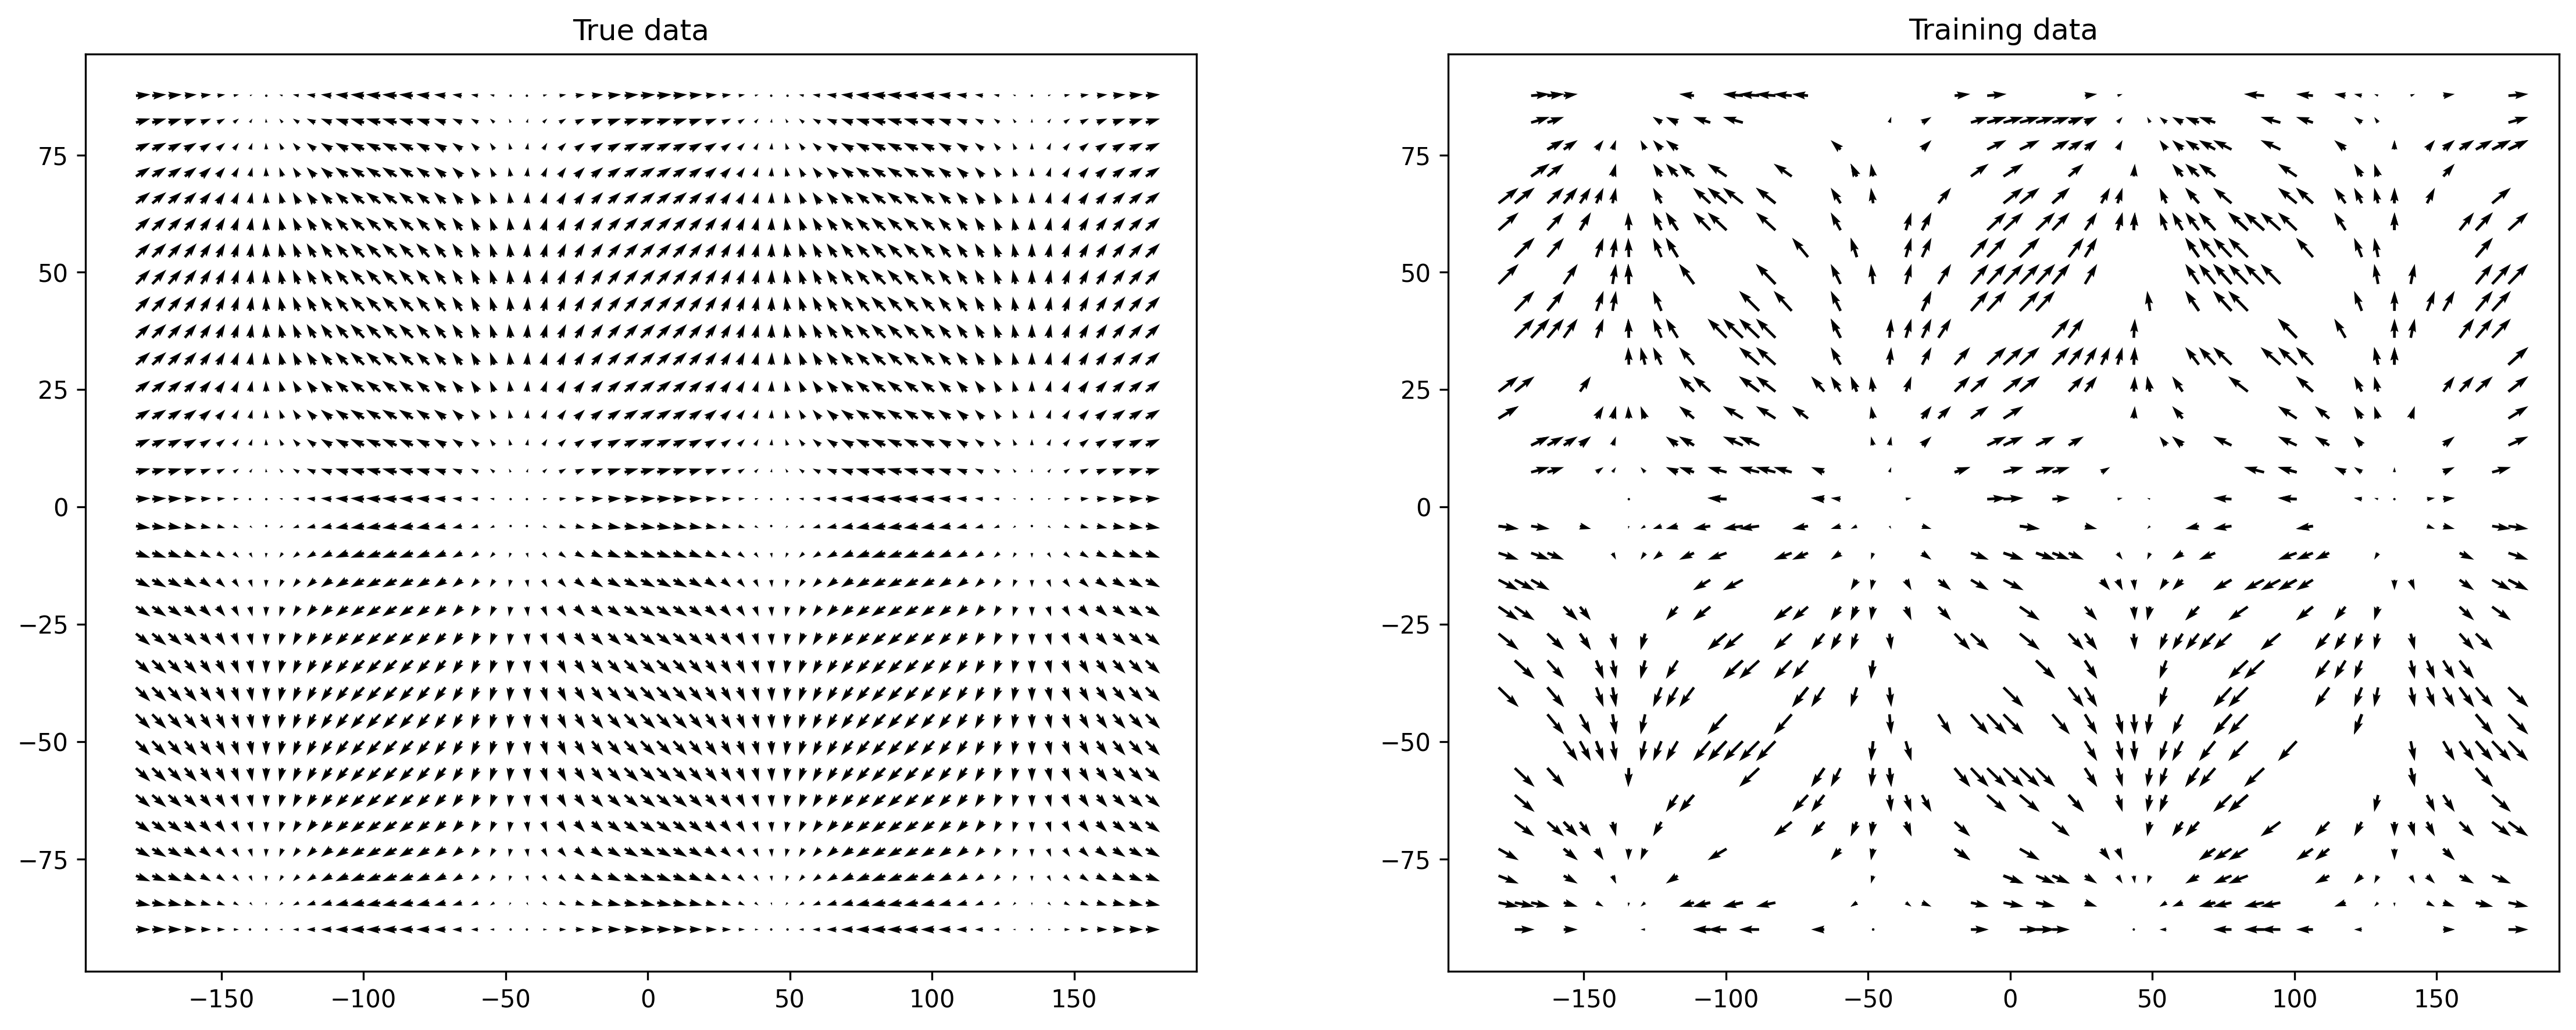

In [3]:
import numpy as np

x = np.arange(-np.pi, np.pi, .1)
y = np.arange(-np.pi/2, np.pi/2, .1)


X, Y = np.meshgrid(x, y)
width = X.shape[0]
height = X.shape[1]

U = np.cos(X*2)
V = np.sin(Y*2)

indices = np.array([(x, y) for x in range(width) for y in range(height)])
sample = np.random.randint(0, indices.shape[0], size=int(indices.shape[0] * 0.5))

X_train = X[indices[sample, 0], indices[sample, 1]]
Y_train = Y[indices[sample, 0], indices[sample, 1]]

U_train = U[indices[sample, 0], indices[sample, 1]]
V_train = V[indices[sample, 0], indices[sample, 1]]


fig, axes = plot.subplots(ncols=2)
fig.tight_layout()
fig.set_size_inches(16, 6)
fig.set_dpi(300)

axes[0].quiver(np.degrees(X), np.degrees(Y), U, V, units='width')
axes[0].set_title("True data")

axes[1].quiver(np.degrees(X_train), np.degrees(Y_train), U_train, V_train, units='width')
axes[1].set_title("Training data")
None

In [4]:
import torch

# The model takes as an input pairs of coordinates and outputs pairs of
# U and V values (direction and strength).
x_coord = np.degrees(X_train).ravel()
y_coord = np.degrees(Y_train).ravel()

x_train = np.column_stack((x_coord, y_coord))
y_train = np.column_stack((U_train.ravel(), V_train.ravel()))

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

## Defining the Model

The model for this problem is constructed using a combination of a 2-dimensional embedding layer and a convolution layer. To reconstruct the original state, we apply a relatively large padding of size 7x7, which allows the gradient distribution to include neighboring cells. The convolution layer then compresses the output from the embedding layer down to a single point.

In [5]:
from torch import nn
from torch.optim import Adam
from torch_geopooling.nn import Embedding2d


class SpatialConv(nn.Module):
    def __init__(self, width, height, embedding_dim=2):
        super().__init__()
        self.embedding = Embedding2d(
            (width, height, embedding_dim),
            padding=(7, 7),
            exterior=(-180, -90, 360, 180)
        )
        self.conv = nn.Conv2d(embedding_dim, 2, (15, 15), dtype=torch.float64)

    def forward(self, x):
        x = self.embedding(x)
        # Before permute shape of the x: (batch_size, w, h, embedding_dim)
        x = x.permute(0, 3, 1, 2)
        # After permute shape of the x: (batch_size, embedding_dim, w, h)
        x = self.conv(x)
        return x

## Training the Model

We train the model using a standard training loop with the Adam optimizer. The process involves initializing the model and optimizer, computing the loss using the L1 loss function, and updating the model parameters through backpropagation. The training loop runs for 30 iterations, during which the model learns to minimize the reconstruction error between the predicted and actual values.

In [6]:
model = SpatialConv(width, height)

loss_fn = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=0.005)

for i in range(30):
    optimizer.zero_grad()

    y_pred = model(x_train)
    loss = loss_fn(y_pred[:, :, 0, 0], y_train)

    loss.backward()
    optimizer.step()

## Evaluating the Model

The image below demonstrates that the trained model closely resembles the patterns found in the original data, even though it was trained on only 50% of the dataset.

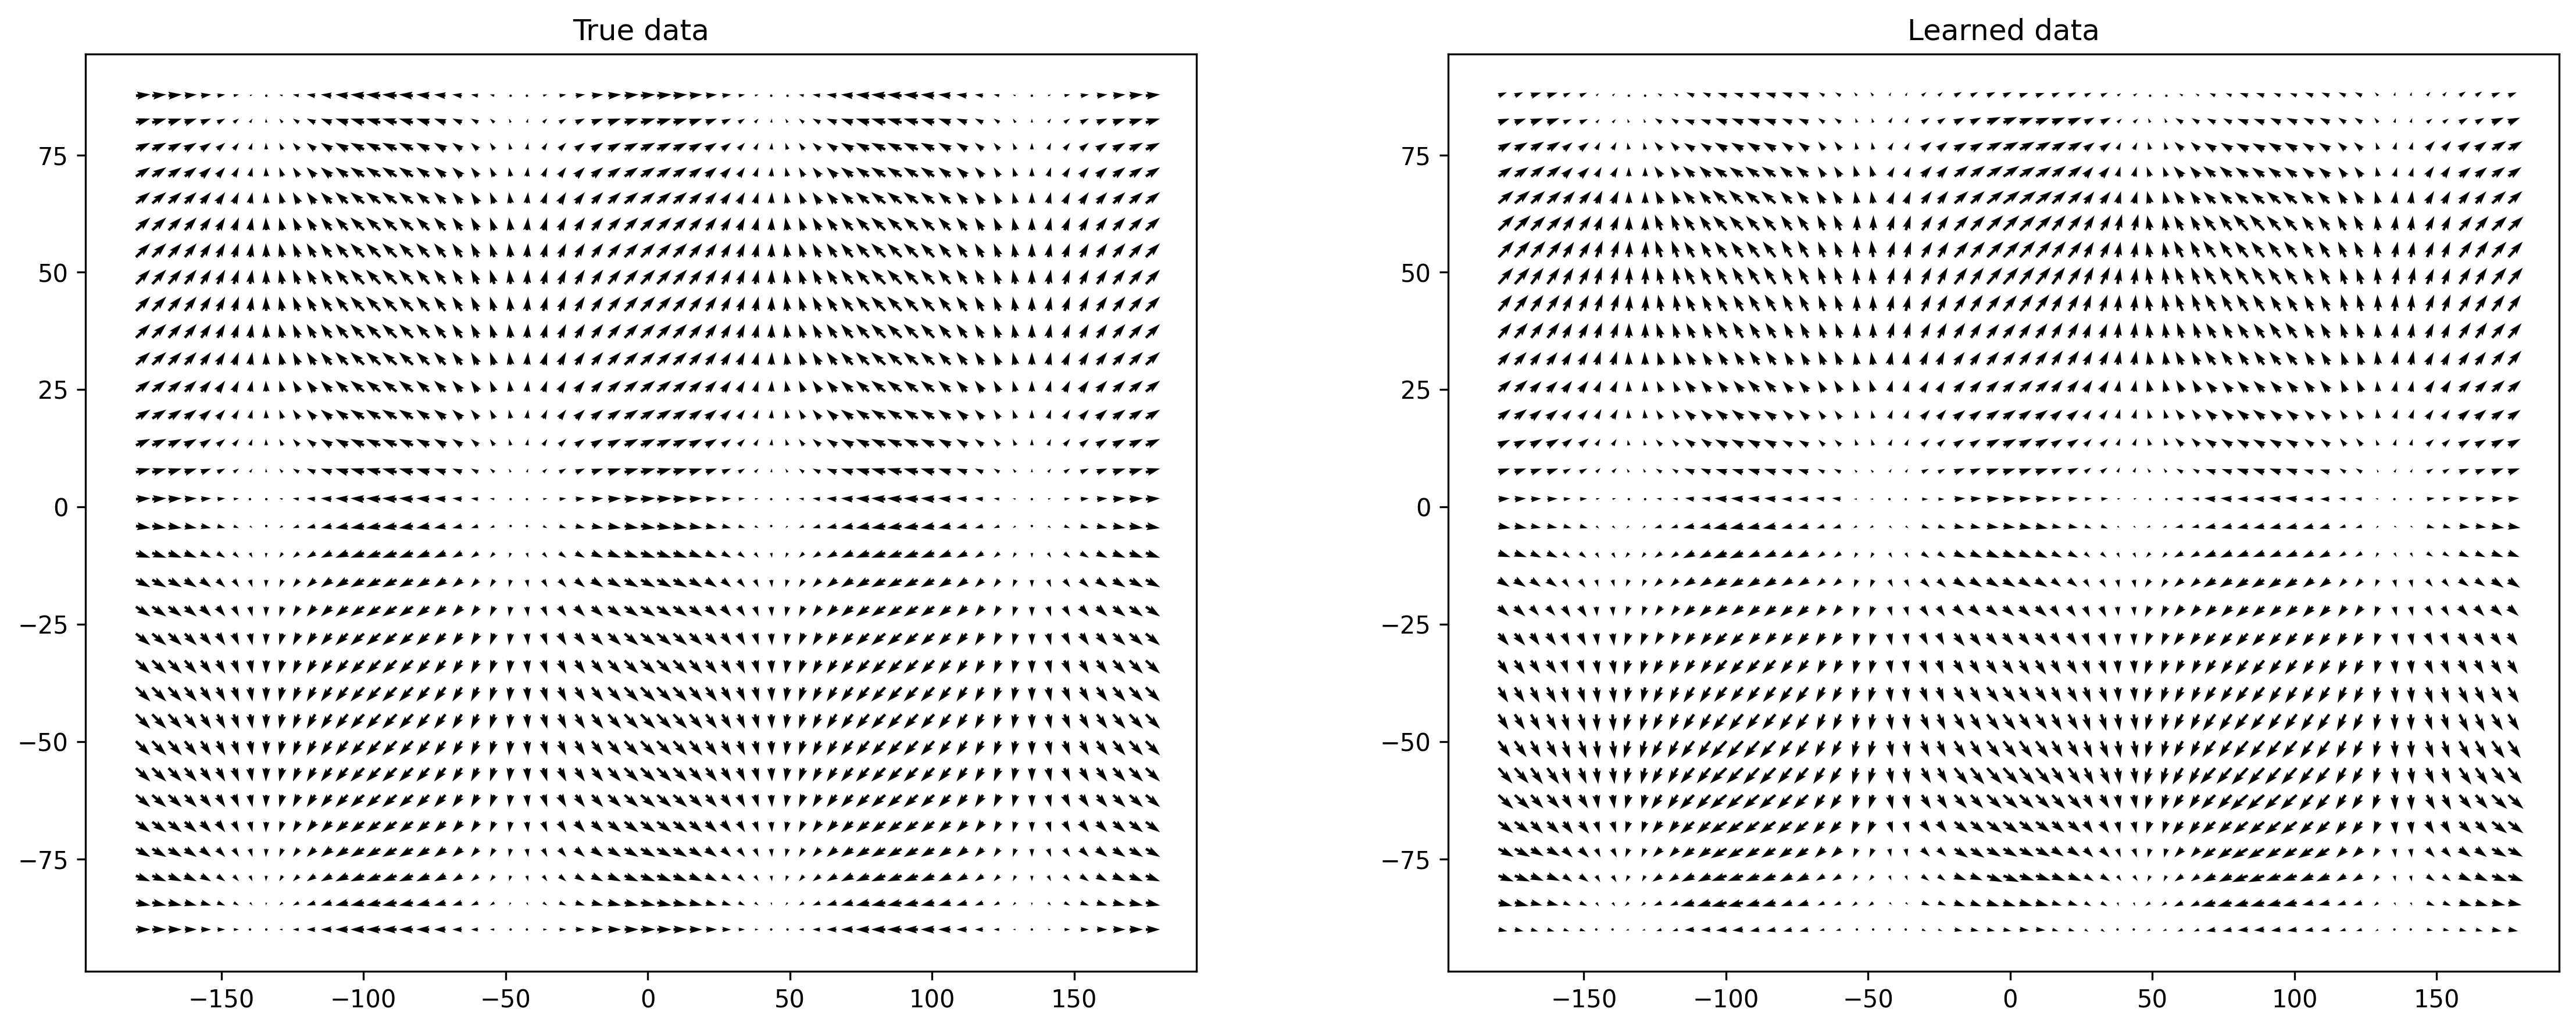

In [7]:
x_test = np.column_stack((np.degrees(X).ravel(), np.degrees(Y).ravel()))
x_test = torch.tensor(x_test, dtype=torch.float64)

y_pred = model.eval()(x_test).detach().numpy()[:, :, 0, 0]
uv = y_pred.reshape(32, 63, 2)


fig, axes = plot.subplots(ncols=2)
fig.tight_layout()
fig.set_size_inches(16, 6)
fig.set_dpi(300)


axes[0].quiver(np.degrees(X), np.degrees(Y), U, V, units='width')
axes[0].set_title("True data")

axes[1].quiver(np.degrees(X), np.degrees(Y), uv[:, :, 0], uv[:, :, 1], units='width')
_ = axes[1].set_title("Learned data")